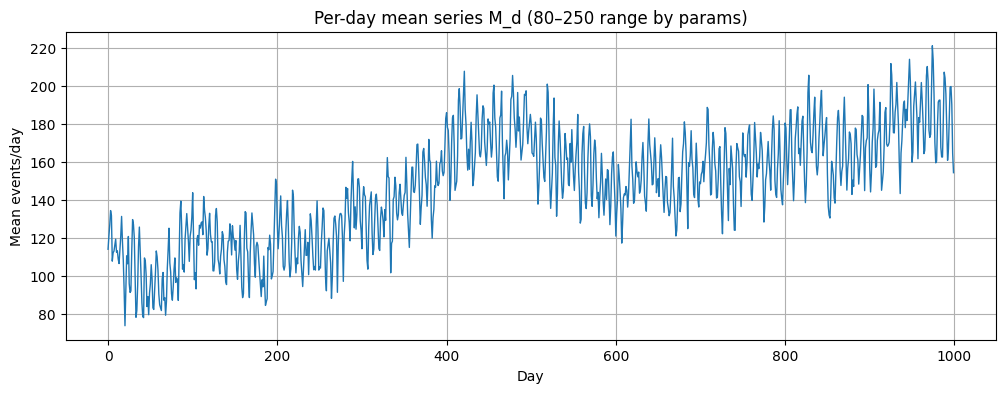

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Set random seed for reproducibility
np.random.seed(0)
D = 1000  # Number of days
days = np.arange(D)

# ------- 1) Linear Trend -------
def make_linear(start=100, end=200):
    """Generate a linear trend from start to end over D days."""
    return np.linspace(start, end, D)

# ------- 2) Exponential Growth -------
def make_exponential(start=100, growth_rate=0.0005):
    """Generate an exponential growth series over D days."""
    return start * np.exp(growth_rate * days)

# ------- 3) Logistic (Saturating) Growth -------
def make_logistic(base=80, K=220, r=0.005, t0=400):
    """Generate a logistic growth curve with saturation."""
    return base + (K - base) / (1 + np.exp(-r * (days - t0)))

# ------- 4) Gaussian Bump (Campaign Effect) -------
def make_gaussian_bump(base=0, peak=50, d0=450, sigma=80):
    """Add a Gaussian-shaped bump to simulate a campaign effect."""
    return base + peak * np.exp(-0.5 * ((days - d0) / sigma) ** 2)

# ------- 5) Weekly Seasonality Multiplier -------
def weekly_seasonality(amplitude=0.10):
    """Apply weekly seasonality as a sinusoidal multiplier."""
    return 1.0 + amplitude * np.sin(2 * np.pi * days / 7.0)

# ------- 6) AR(1) Noise with Drift -------
def ar1_noise(phi=0.7, sigma=5, drift=0.0):
    """Generate autocorrelated AR(1) noise with optional drift."""
    eps = np.random.normal(0, sigma, size=D)
    x = np.zeros(D)
    x[0] = eps[0]
    for i in range(1, D):
        x[i] = phi * x[i-1] + eps[i]
    return x + drift * days

# ------- Build Composite Daily Mean Series -------
linear_part = make_linear(100, 180)  # Linear trend component
season = weekly_seasonality(amplitude=0.10)  # Weekly seasonality
campaign = make_gaussian_bump(base=0, peak=40, d0=450, sigma=80)  # Campaign effect
noise = ar1_noise(phi=0.7, sigma=8, drift=0.0)  # AR(1) noise

# Combine all components to form the daily mean series
M_d = (linear_part + campaign) * season + noise

# ------- Plot Daily Means -------
plt.figure(figsize=(12, 4))
plt.plot(days, M_d, lw=1)
plt.title("Per-day mean series M_d (80–250 range by params)")
plt.xlabel("Day")
plt.ylabel("Mean events/day")
plt.grid(True)
plt.show()

In [ ]:
# ================= Hourly Expansion =================
def generate_hourly_means_for_days(
    mean_arrival_rates, M_d, weekend_multiplier=0.9, peak_boost_strength=1.5,
    daily_amplifier_smoothing=7, hourly_jitter_std_frac=0.05, weekday_effect=True
):
    """
    Generate hourly mean arrival rates for each day, incorporating daily trends,
    seasonality, weekend effects, peak boosting, and autocorrelated hourly noise.

    Parameters:
        mean_arrival_rates (array-like): Typical hourly arrival rates (length 24).
        M_d (array-like): Daily mean arrival rates (length D).
        weekend_multiplier (float): Multiplier for weekends.
        peak_boost_strength (float): Strength of daily peak boosting.
        daily_amplifier_smoothing (float): Smoothing factor for amplifier calculation.
        hourly_jitter_std_frac (float): Fractional std for hourly noise.
        weekday_effect (bool): Whether to apply weekend effect.

    Returns:
        np.ndarray: Matrix of shape (D, 24) with hourly means for each day.
    """
    M_d = np.asarray(M_d).astype(float)
    D = len(M_d)
    days = np.arange(D)

    # Normalize the hourly template to get relative hourly pattern
    template = np.asarray(mean_arrival_rates, dtype=float)
    rel_pattern = template / template.mean()

    # Smooth daily means to compute amplifier (captures local peaks/troughs)
    smoothed = gaussian_filter1d(M_d, sigma=daily_amplifier_smoothing / 2.0, mode='reflect')
    amplifier = (M_d / (smoothed + 1e-9)) - 1.0
    amplifier = np.clip(amplifier, -0.8, 2.0)

    hourly_means = np.zeros((D, 24), dtype=float)

    for i in range(D):
        day_mean = float(M_d[i])
        a = float(amplifier[i])

        # Determine if current day is weekend
        if weekday_effect:
            weekday = int(days[i] % 7)
            is_weekend = (weekday in (5, 6))
            day_weekend_mul = weekend_multiplier if is_weekend else 1.0
        else:
            day_weekend_mul = 1.0

        # Calculate peakness factor for the day
        peakness = 1.0 + (a * peak_boost_strength)

        # Compute baseline hourly means for the day
        baseline_hour = rel_pattern * peakness * day_weekend_mul * (day_mean ** 0.9)

        # Add autocorrelated AR(1) noise to hourly means
        phi = 0.6
        sigma_hour = hourly_jitter_std_frac * np.mean(baseline_hour)
        eps = np.random.normal(scale=sigma_hour, size=24)
        ar_noise = np.zeros(24)
        ar_noise[0] = eps[0]
        for h in range(1, 24):
            ar_noise[h] = phi * ar_noise[h - 1] + eps[h]

        # Final hourly values for the day, clipped to non-negative
        hvals = baseline_hour + ar_noise
        hvals = np.clip(hvals, 0, None)

        hourly_means[i, :] = hvals

    return hourly_means

# Define typical 24-hour arrival shape
mean_arrival_rates = np.array([
    80, 60, 40, 30, 40, 50, 70, 100, 75, 70, 80, 90,
    100, 90, 100, 120, 110, 160, 170, 180, 200, 160, 130, 90
])

# Generate hourly mean matrix for all days
hourly_matrix = generate_hourly_means_for_days(mean_arrival_rates, M_d)

# Save hourly means to CSV for further analysis
df = pd.DataFrame(hourly_matrix, columns=[f"Hour_{h:02d}" for h in range(24)])
df.insert(0, "Day", np.arange(D))
df.to_csv("hourly_mean.csv", index=False)


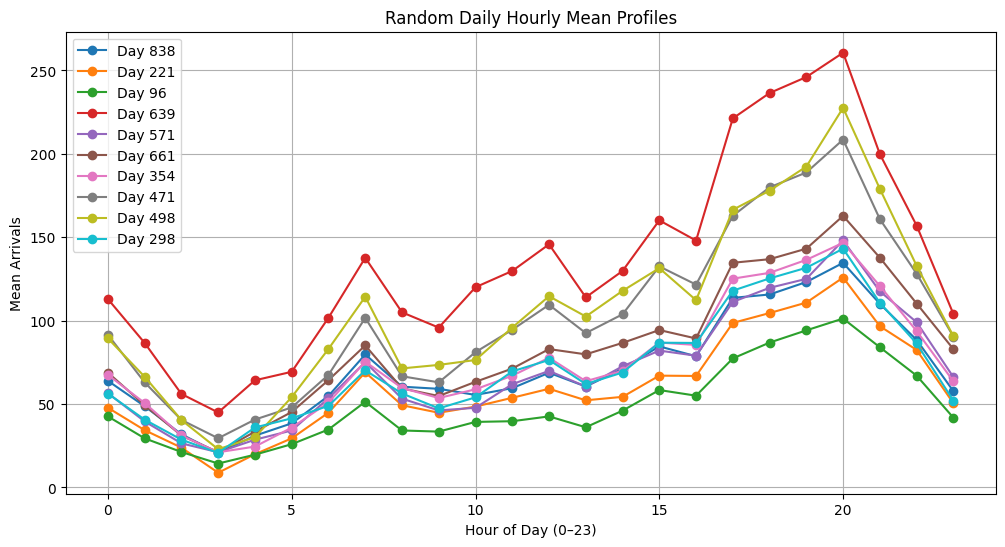

In [ ]:
import random

# Select 10 random days from the available range
random_days = random.sample(range(D), 10)

plt.figure(figsize=(12, 6))
for d in random_days:
    # Plot the hourly mean arrivals for each selected day
    plt.plot(range(24), hourly_matrix[d], marker='o', label=f"Day {d}")

plt.xlabel("Hour of Day (0–23)")
plt.ylabel("Mean Arrivals")
plt.title("Random Daily Hourly Mean Profiles")
plt.legend()
plt.grid(True)
plt.show()
